In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Homework 4

In this week's assigment we try to solve the following points:

- Generate a random a SxS matrix with C non zero entries and 1-C zeros (C is between zero and one). Set the diagonal to -d. The non-zero elements are drawn from a given distributions. Calculate the eigenvalues. Repeat different realizations and plot all the eigenvalues in the complex plane [Real part (x-axis) and imaginary part (y-axis)]. Compare this result with the expectations from the circular law.

- Generate the same as above but for mutualistic structure and find how the maximum real eigenvalues scales with S (use S=20,30,40,..100) and compares your numerical finding with the analytical expectations (we did not explicitly have calculated this in class).

- Analyse the food web using the metrics we have seen in class. The file represent the weighted adjacency matrix of the food web. For the analysis you can binarize (zero and one) the matrix. You find the file in the google drive.

- Optional: calculate the same as 1) but with for the cascade model or for the nested mutualistic network. 

## 1) Random matrix

In [114]:
tmp = np.random.rand(50)
np.concatenate([tmp, -tmp]).reshape((10, 10))

array([[ 0.00589425,  0.50166574,  0.64800828,  0.29030359,  0.12424242,
         0.57557389,  0.4725028 ,  0.42478442,  0.77701597,  0.28743797],
       [ 0.59941088,  0.41539028,  0.51145832,  0.65959506,  0.98042997,
         0.04578276,  0.80460637,  0.02635587,  0.60121954,  0.98509219],
       [ 0.82486248,  0.55704566,  0.19431122,  0.25973744,  0.97908402,
         0.12817866,  0.2097362 ,  0.92019129,  0.24217818,  0.37222502],
       [ 0.12241089,  0.83592061,  0.38758437,  0.01752409,  0.7658641 ,
         0.92956194,  0.74443816,  0.69821428,  0.71720505,  0.89260827],
       [ 0.21042891,  0.56789775,  0.45576629,  0.23183937,  0.97337144,
         0.59865325,  0.90681566,  0.82577369,  0.08651438,  0.85862795],
       [-0.00589425, -0.50166574, -0.64800828, -0.29030359, -0.12424242,
        -0.57557389, -0.4725028 , -0.42478442, -0.77701597, -0.28743797],
       [-0.59941088, -0.41539028, -0.51145832, -0.65959506, -0.98042997,
        -0.04578276, -0.80460637, -0.02635587

In [115]:
def random_matrix(S, C, d, distribution, parameters):

    # Generate a random a SxS matrix with non zero entries hsving a probability of C 
    # Set the diagonal to -d. 

    # S: number of species
    # C: percentage of non zero entries
    # d: diagonal value
    # distribution: numpy random distribution of the non zero entries
    # parameters: parameters of the numpy distribution (has to be a dictionary)

    # Generate a random matrix
    matrix = distribution(size=(S, S), **parameters)
    

    
    # Set the diagonal to -d
    np.fill_diagonal(matrix, -d)

    # Set the off-diagonal non zero entries to zero with a probability of 1-C
    matrix[np.triu(np.random.uniform(size = (S, S)), k = 1) > C]=0
    matrix[np.tril(np.random.uniform(size = (S, S)), k = -1) > C]=0

    


    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    
    

    return eigenvalues

In [116]:
realizations_number = 1000
S = 100
C = 0.7
d = 5
distribution = np.random.normal
std = 0.5
parameters={'loc': 0, 'scale': std}


print(f'''
The theoretical mean of the real part of the eigenvalues is: {-d}
The theoretical mean of the imaginary part of the eigenvalues is: {0}
The theoretcal radius of the circle is {std * np.sqrt(S * C) :.2f}''')


The theoretical mean of the real part of the eigenvalues is: -5
The theoretical mean of the imaginary part of the eigenvalues is: 0
The theoretcal radius of the circle is 4.18


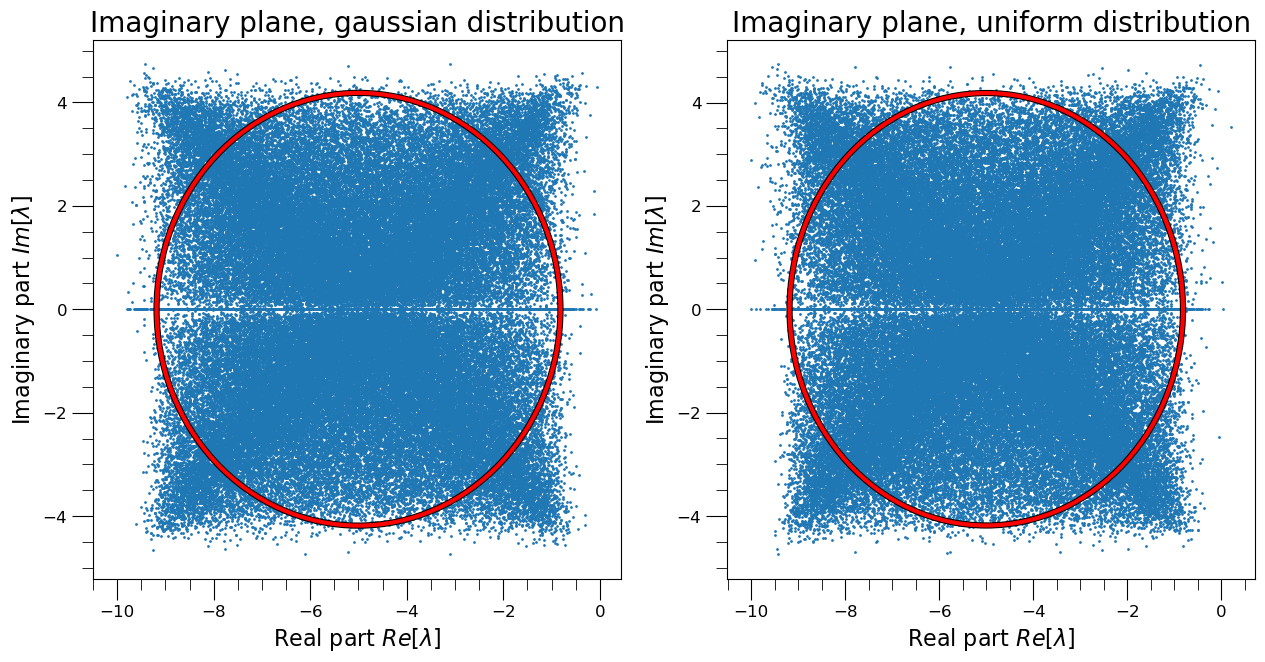

In [117]:
fig, ax_ = plt.subplots(1, 2, figsize=(15, 7))


distributions = {'gaussian': np.random.normal, 'uniform': np.random.uniform}

extrema = std * np.sqrt(3)
parameters = {'gaussian': {'loc': 0, 'scale': std}, 'uniform': {'low': -extrema, 'high': extrema}}

for i, ax in enumerate(ax_):
    all_real_parts = [random_matrix(S, C, d, list(distributions.values())[i], list(parameters.values())[i]).real for j in range(realizations_number)]
    all_imag_parts = [random_matrix(S, C, d, list(distributions.values())[i], list(parameters.values())[i]).imag for j in range(realizations_number)]    

    ax.scatter(np.concatenate(all_real_parts), np.concatenate(all_imag_parts), s = 1)
    #ax.Circle((-d, 0), std * np.sqrt(S * C), color='red', fill=False) 
    ax.add_patch(plt.Circle((-d, 0), std * np.sqrt(S * C), color='red', fill=False, linewidth = 3, zorder = 2))
    ax.add_patch(plt.Circle((-d, 0), std * np.sqrt(S * C), color='black', fill=False, linewidth = 4.5, zorder = 1))
    ax.set_title(f'Imaginary plane, {list(distributions.keys())[i]} distribution', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=12, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
    ax.minorticks_on()
    ax.set_xlabel('Real part $Re[\\lambda]$', fontsize = 16)
    ax.set_ylabel('Imaginary part $Im[\\lambda]$', fontsize = 16)
   

plt.show()


In [118]:
tmp = np.random.normal(size = 100*100, loc = 0, scale = 0.5)
tmp_2 = tmp.copy()
tmp_2[np.random.uniform(size = 100*100) > 0.7] = 0
print(np.mean(np.abs(tmp)))
print(0.7 * np.mean(np.abs(tmp)))
print(np.mean(np.abs(tmp_2)))
print((np.std(np.abs(tmp))**2) + (np.mean(np.abs(tmp))**2))
print(np.std(np.abs(tmp_2))**2 + np.mean(np.abs(tmp_2))**2)
print('------------')
print(0.7 * np.mean(np.abs(tmp)**2) - 0.7**2 * np.mean(np.abs(tmp))**2) 
print(np.mean(np.abs(tmp_2)**2) - np.mean(np.abs(tmp_2))**2) 

0.3950837022788168
0.2765585915951717
0.27509157418679114
0.24460882465195172
0.1693217402964779
------------
0.0947415226712612
0.09364636610791113


In [119]:
tmp_11 = np.random.normal(size = 100*50, loc = 0, scale = 0.5)
mean_1 = np.mean(np.abs(tmp_11))
tmp_11[np.random.uniform(size = 100*50) > 0.7] = 0
tmp_11 = np.abs(tmp_11)
tmp_13 = np.random.normal(size = 100*50, loc = 0, scale = 0.5)
mean_2 = np.mean(np.abs(tmp_13))
tmp_13[np.random.uniform(size = 100*50) > 0.7] = 0
tmp_13 = np.abs(tmp_13)
tmp_12 = tmp_11.copy()
tmp_list = []
for i in range(len(tmp_11)):
    for j in range(len(tmp_12)):
        if i != j:
            tmp_list.append(tmp_11[i] * tmp_12[j])

tmp_2_list = []
for i in range(len(tmp_11)):
    for j in range(len(tmp_13)):
        if i != j:
            tmp_2_list.append(tmp_11[i] * tmp_13[j])


print(0.7**2 * mean_1**2)
print(0.7**2 * mean_2**2)
print(np.mean(tmp_11)**2)
print(np.mean(tmp_list))
print(np.mean(tmp_2_list))

0.07422389721198303
0.07785062115056234
0.07387548864827112
0.07385691688310363
0.07449172580443887


## Observations
---
We can see that our the eigenvalue distribution does not quite resemble the one predicted by ther circular law. The eigenvalues indeed are both not uniformly distributed neither they are placed inside the teorethical circle. <br>
We gotta remember though that the derivation of the law is based on the strong assumption of the existance of an equilibrium $N^*_s = (1, 1, ..., 1)$ that allows us to write $J_{ij} = \alpha_{ij}$ with $\alpha$ our adjacency matrix. <br>
Furthermore the result does not vary significantly, as expected, between the 2  distribution chosen. <br>



## 2) Mutualistic structure

In this second section of the notebook we study the case in which we introduce correlation between each species, we will use a Gaussian with mean $0$ as our distribution. <br>
What is found analytically is that in the complex plane we now have an ellipse with semi-axis dependent on the values of the correlation coefficient $\rho$. In particular, <br>

<br/>

$$

\begin{cases}

a \approx \sqrt{S \cdot V} \cdot (1 + \rho) \\
\\
b \approx \sqrt{S \cdot V} \cdot (1 - \rho) \\

\end{cases}
$$

Where $V$ is the variance of the distribution of the interaction strengths $\quad V = Var(\alpha_{ij}) \quad$ and $\rho$ is the correlation defined as $ \quad \rho =\dfrac{ \mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] - \mathbb{E} ^2 
\big[ \alpha_{i,j} \big] }{Var(\alpha_{i,j})}$. <br>

<br/>

Before computing the variables of interest we begin by describing the procedure used to generate the random matrix $\alpha_{i,j}$. <br>
At each step we draw from a random distribution two independent numbers $x_1$ and $x_2$, to build the matrix with the correct structure we then apply a tranformation $x_1$ and $x_2$, for a predator-prey interaction we have $x_1 \rightarrow |x_1|$, $x_2 \rightarrow -|x_2|$, for a mutualistic interaction instead we have $x_1 \rightarrow |x_1|$, $x_2 \rightarrow |x_2|$. <br>

<br/>

In order to compute $\mathbb{E}[\alpha_{ij}]$ we notice that by construction, it is nothing different from $\mathbb{E}[|x|]$ or better, in our case, $C \cdot \mathbb{E}[|x|]$ which is,

$$

\mathbb{E}[|x|] = \int_{-\infty}^{\infty} |x| \cdot P(x) \cdot dx = \int_{-\infty}^{\infty} |x| \dfrac{1}{\sigma\sqrt{2 \pi}} e^{-\frac{x^2}{2 \sigma^2}} \cdot dx \quad =

$$

$$

\quad = \dfrac{2}{\sigma\sqrt{2 \pi}} \cdot \int_{0}^{\infty} xe^{-\frac{x^2}{2 \sigma^2}} \cdot \mathcal{d}x \quad \text{making the change of variable} \quad u = \frac{x^2}{2 \sigma^2} \quad \text{we get} \quad

$$

$$

\dfrac{2}{\sigma\sqrt{2 \pi}} \cdot \int_{0}^{\infty} e^{- \frac{u}{\sigma^2}} \mathcal{d}u = \dfrac{2 \sigma}{\sqrt{2 \pi}} 

$$



and with a similar reasoning we have $\mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] = C^2 \cdot \mathbb{E}^2 \big[ |x| \big]$.

<br/>

From all this follows that $ \quad \rho =\dfrac{ \mathbb{E} \big[ \alpha_{i,j} \alpha_{j,i} \big] - \mathbb{E} ^2 
\big[ \alpha_{i,j} \big] }{Var(\alpha_{i,j})} = 0$

<br/>

We also compute the variance $Var(\alpha_{ij}) = \mathbb{E[x^2]} - \mathbb{E[\big|x\big|]^2}$ which is given by,

$$

Var(\alpha_{ij}) = \mathbb{E[x^2]} - \mathbb{E[\big|x\big|]^2} = C \cdot \sigma^2 - C^2 \cdot \dfrac{2 \sigma^2}{\pi} = C \sigma^2 \cdot (1 - C \cdot \dfrac{2}{\pi})

$$


### Verifying the analytical results

Before carrying on ioth the notebook we choose to verify numerically the analytical results written above on a random matrix. <br>

In [120]:
n_species = 100
std = 0.5
d = 5
C = 0.7

random_matrix = np.random.normal(size = (n_species, n_species), loc = 0, scale = std)
random_matrix = np.abs(random_matrix)
np.fill_diagonal(random_matrix, -d)




off_diagonal_mask = np.eye(random_matrix.shape[0], dtype = bool)
off_diagonal_indexes = np.where(~ off_diagonal_mask)

off_diagonal_values = random_matrix[off_diagonal_indexes].flatten()
var_c1 = np.var(off_diagonal_values)
mean_c1 = np.mean(off_diagonal_values)

# Set the off-diagonal non zero entries to zero with a probability of 1-C
off_diagonal_values[(np.random.uniform(size = S*S - S)) > C] = 0

print(f'''
The theoretical mean of the off diagonal terms with C = 1 is {(2* 0.5)/(np.sqrt((2 * np.pi))):.3f}
The numerical mean of the off diagonal term is {mean_c1:.3f}
The theoretical mean of the off diagonal terms with C = 0.7 is {0.7 * (2* 0.5)/(np.sqrt((2 * np.pi))):.3f}
The numerical mean of the off diagonal terms with C = 0.7 is, {np.mean(off_diagonal_values):.3f}
The 0.7 times the numerical mean is, {C * mean_c1:.3f}
''')
print('-------------------------')

upper_diagonal_terms_0 = random_matrix[np.triu_indices(n_species, k = 1)].flatten()
upper_diagonal_terms = upper_diagonal_terms_0[np.where(upper_diagonal_terms_0 > 0)]
original_upper = upper_diagonal_terms.copy()
upper_diagonal_terms[(np.random.uniform(size = (S*S - S)//2)) > C] = 0

lower_diagonal_terms_0 = random_matrix[np.tril_indices(n_species, k = -1)].flatten()
lower_diagonal_terms = lower_diagonal_terms_0[np.where(lower_diagonal_terms_0 > 0)]
original_lower = lower_diagonal_terms.copy()
lower_diagonal_terms[(np.random.uniform(size = (S*S - S)//2)) > C] = 0

product_terms_C = np.multiply(upper_diagonal_terms, lower_diagonal_terms)
product_terms_no_C = np.multiply(original_upper, original_lower)

print(f'''
The theoretical mean of the product terms aij * aji with C = 1 is {(2* 0.5)/(np.sqrt((2 * np.pi)))**2:.3f}
The numerical mean of the product terms aij * aji with C = 1 is {np.mean(product_terms_no_C):.3f}
The theoretical mean of the product terms aij * aji with C = 0.7 is {0.7**2 * (2* 0.5)/(np.sqrt((2 * np.pi)))**2:.3f}
The numerical mean of the product terms aij * aji with C = 0.7 is, {np.mean(product_terms_C):.3f}
C^2 times the numerical mean is, {C**2 * np.mean(product_terms_no_C):.3f}
''')

print('-------------------------')


print(f'''
The theoretical variance of the off diagonal terms with C = 1 is {(std ** 2) * (1 - 2/np.pi):.3f}
The numerical variance of the off diagonal term is {var_c1:.3f}
The theoretical variance of the off diagonal terms with C = 0.7 is {C * (std ** 2) * (1 - (2 * C)/np.pi):.3f}
The numerical variance of the off diagonal terms with C = 0.7 is, {np.var(off_diagonal_values):.3f}
''')

print('-------------------------')


cov = np.cov(random_matrix)
upper_triangular_cov = cov[np.triu_indices(n_species, k = 1)].flatten()
upper_triangular_cov = upper_triangular_cov[np.where(upper_triangular_cov > 0)]

lower_triangular_cov = cov[np.tril_indices(n_species, k = -1)].flatten()
lower_triangular_cov = lower_triangular_cov[np.where(lower_triangular_cov > 0)]

mean_cov = np.mean(np.concatenate((upper_triangular_cov, lower_triangular_cov)))



print(f'''
We can also verify that the correlation is 0 printing the mean of the off-diagonal matric of the covariance matrix (we do it for the case of C = 1 without loss of generality), that is: {mean_cov:.3f}
''')


The theoretical mean of the off diagonal terms with C = 1 is 0.399
The numerical mean of the off diagonal term is 0.391
The theoretical mean of the off diagonal terms with C = 0.7 is 0.279
The numerical mean of the off diagonal terms with C = 0.7 is, 0.279
The 0.7 times the numerical mean is, 0.274

-------------------------

The theoretical mean of the product terms aij * aji with C = 1 is 0.159
The numerical mean of the product terms aij * aji with C = 1 is 0.153
The theoretical mean of the product terms aij * aji with C = 0.7 is 0.078
The numerical mean of the product terms aij * aji with C = 0.7 is, 0.074
C^2 times the numerical mean is, 0.075

-------------------------

The theoretical variance of the off diagonal terms with C = 1 is 0.091
The numerical variance of the off diagonal term is 0.087
The theoretical variance of the off diagonal terms with C = 0.7 is 0.097
The numerical variance of the off diagonal terms with C = 0.7 is, 0.094

-------------------------

We can also ve

We could thing that having a correlation coefficient of zero with $0$ we would have something remembering very closely the case with no mutualistic structure with the main difference being the radius of the circle $r = \sqrt{Var \cdot S}$ having now a different value of the Variance. <br>
We can see though how the mean of the distribution is not zero, but it is in fact $C \cdot \mathbb{E}[|x|]$ bringing to us the "outlier" eigenvalue at $(S - 1) \cdot C \mathbb{E}[|x|] \quad = \quad C \cdot (S - 1) \cdot 
\dfrac{2 \sigma}{\sqrt{2 \pi}}$, let's verify it graphically with an example.

<br/>

In order to do it properly we 

In [121]:
def mutualistic_random_matrix(S, C, d, distribution, parameters):

    # Generate a random a SxS matrix with non zero entries hsving a probability of C 
    # Set the diagonal to -d. 

    # S: number of species
    # C: percentage of non zero entries
    # d: diagonal value
    # distribution: numpy random distribution of the non zero entries
    # parameters: parameters of the numpy distribution (has to be a dictionary)

    # Generate a random matrix
    matrix = distribution(size=(S, S), **parameters)
    matrix = np.abs(matrix)

    
    # Set the diagonal to -d
    np.fill_diagonal(matrix, -d)

    # Set the off-diagonal non zero entries to zero with a probability of 1-C
    matrix[np.triu(np.random.uniform(size = (S, S)), k = 1) > C]=0
    matrix[np.tril(np.random.uniform(size = (S, S)), k = -1) > C]=0

    


    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    
    

    return eigenvalues

In [122]:
all_real_parts = [mutualistic_random_matrix(S, C, d, distributions['gaussian'], parameters['gaussian']).real for j in range(realizations_number)]
all_imag_parts = [mutualistic_random_matrix(S, C, d, distributions['gaussian'], parameters['gaussian']).imag for j in range(realizations_number)]    

In [153]:
print(f'''
We expect the system to be unstable as the real part of the "outlier" eigenvalue is {C * (S - 1) * ((2 * std) / (np.sqrt(2 * np.pi))) - d:.3f} 




''')


We expect the system to be unstable as the real part of the "outlier" eigenvalue is 22.647 







/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


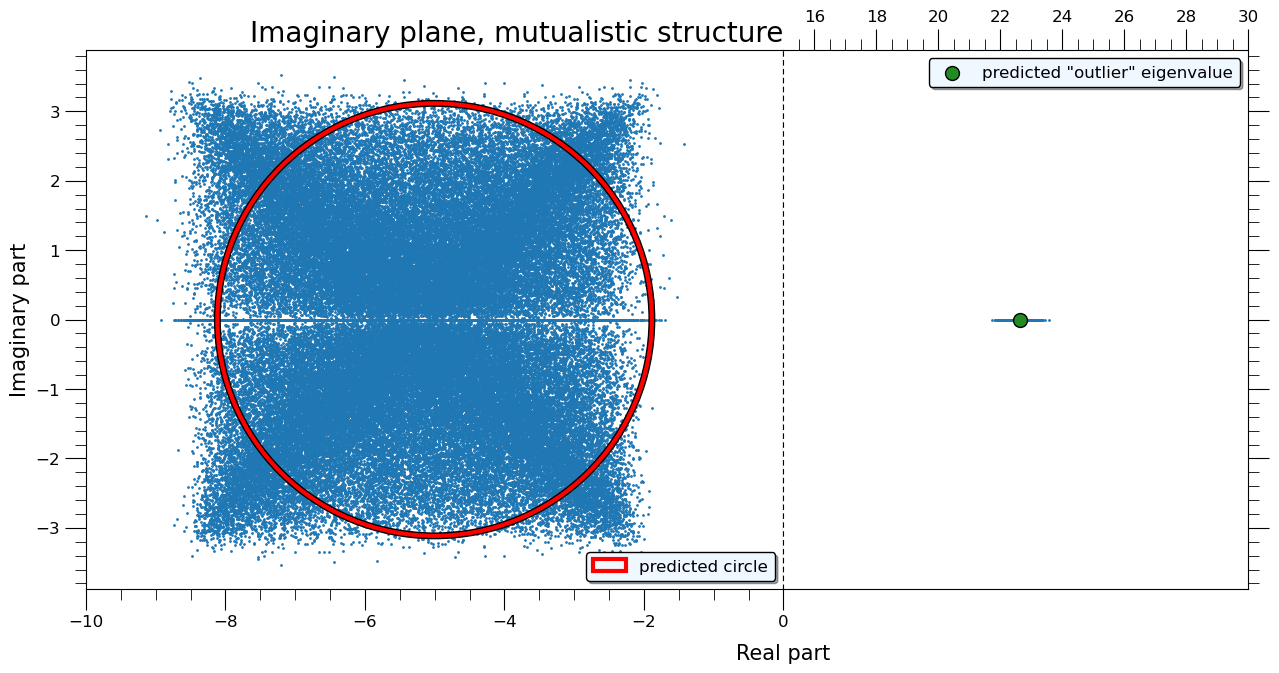

In [145]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7), sharey=True, gridspec_kw={'wspace': 0, 'width_ratios': [3, 2]})
ax1.scatter(np.concatenate(all_real_parts), np.concatenate(all_imag_parts), s = 1, color = 'C0')
ax1.set_xlim(-10, 0)
ax2.scatter(np.concatenate(all_real_parts), np.concatenate(all_imag_parts), s = 1, color = 'C0')
ax2.set_xlim(15, 30)
ax2.spines['left'].set_linestyle((0, (4, 4)))
ax1.add_patch(plt.Circle((-d, 0), np.sqrt(C * std**2 * (1 - C * (2 / np.pi)) * S), color='red', fill=False, linewidth = 3, zorder = 2, label = 'predicted circle'))
ax1.add_patch(plt.Circle((-d, 0), np.sqrt(C * std**2 * (1 - C * (2 / np.pi)) * S), color='black', fill=False, linewidth = 5, zorder = 1))
ax2.scatter(C * (S - 1) * ((2 * std) / (np.sqrt(2 * np.pi))) - d, 0, edgecolor = 'black', color = 'forestgreen', s = 100, zorder = 3, label = 'predicted "outlier" eigenvalue')
ax2.xaxis.tick_top()

ax1.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, fontsize = 12)
ax2.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True, fontsize = 12)
ax2.yaxis.tick_right()

for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=12, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=8)

ax1.set_xlabel('Real part', fontsize = 15)
ax1.set_ylabel('Imaginary part', fontsize = 15)
ax1.xaxis.set_label_coords(1, -.1)

ax1.set_title('Imaginary plane, mutualistic structure', fontsize = 20, loc = 'right')

plt.show()


## Observations

We can immediately notice how the eigenvalue caused by the matrix non having mean $0$ makes the system unstable as its Real part is greater then zero.<br>
As in the previous case there is difference from the analytical expectation expecially on the shape of the eigenvalue distribution. <br>
We restate that the analytical results though lie on the strong assumption of the existance of an equilibrium $N^*_s = (1, 1, ..., 1)$ that allows us to write $J_{ij} = \alpha_{ij}$ with $\alpha$ our adjacency matrix. 


## Scaling of the Maximum Eigenvalue

In this section we study how the maximum real part between all the eigenvalues scales at various values of the number of species $S$ we choose as values of $S = [20, ..., 100]$. <br>
We expect to find something linear as 

In [154]:
range_species = np.arange(20, 101, 10)

In [161]:
max_eigenvalues = [np.max([mutualistic_random_matrix(species, C, d, distributions['gaussian'], parameters['gaussian']).real for j in range(realizations_number)]) for species in range_species]

In [163]:
((2* 0.5)/(np.sqrt((2 * np.pi))))**2 * 0.7**2 * 100

7.7985922115028705

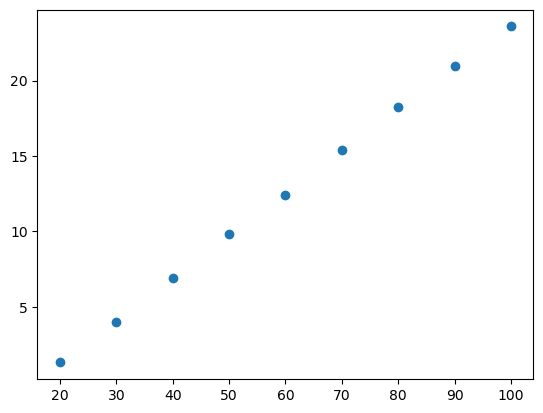

In [162]:
plt.scatter(range_species, max_eigenvalues)

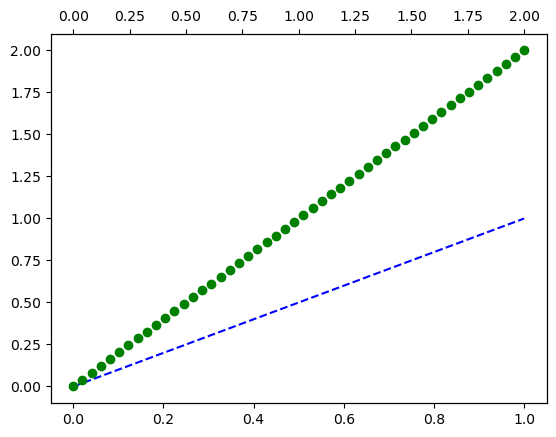

In [73]:
# plot f(x)=x for two different x ranges
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 2, 50)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(x1, x1,'b--')

ax2 = ax1.twiny()
ax2.plot(x2, x2, 'go')

plt.show()

In [74]:
distributions = {'uniform': np.random.uniform, }

In [75]:
all_real_parts = [random_matrix(10, C, d, distribution, parameters).real for i in range(2)]
all_imag_parts = [random_matrix(10, C, d, distribution, parameters).imag for i in range(2)]

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
np.concatenate(all_real_parts)

array([-3.82263921, -3.82263921, -5.03677772, -5.03677772, -5.87719336,
       -5.87719336, -5.66351792, -4.82948869, -4.82948869, -5.20428412,
       -5.92737392, -5.92737392, -4.87098464, -4.87098464, -4.07931774,
       -4.22973693, -4.58957413, -4.58957413, -5.45753998, -5.45753998])

In [ ]:
tmp = np.random.normal(size = (3, 3))
np.fill_diagonal(tmp, -5)
tmp

array([[-5.        , -1.21605265,  0.86505355],
       [ 0.10597817, -5.        ,  0.48862924],
       [ 1.08501026,  2.53643929, -5.        ]])

In [ ]:
tmp[np.triu_indices(3, 1)]

array([ 1.39255115, -0.11640303, -0.24261123])

In [ ]:
tmp[tmp[np.random.randn(size = np.triu_indices(3))]]

array([[-0.35213768,  1.39255115, -0.11640303],
       [ 0.39850111, -1.29097338, -0.24261123],
       [ 0.99684264, -0.57852178,  0.65993846]])

In [ ]:
np.tril(np.random.uniform(size = (3, 3)), k = -1)

array([[0.        , 0.        , 0.        ],
       [0.90343028, 0.        , 0.        ],
       [0.17459724, 0.41866036, 0.        ]])

In [ ]:
tmp[np.triu(tmp_2 := np.random.uniform(size = (3, 3)), k = 1) > 1 - 0.2]=0
tmp

array([[-0.35213768,  0.        , -0.11640303],
       [ 0.39850111, -1.29097338, -0.24261123],
       [ 0.99684264, -0.57852178,  0.65993846]])

In [ ]:
np.random.uniform(size = (3, 3))

array([[0.43194502, 0.29122914, 0.61185289],
       [0.13949386, 0.29214465, 0.36636184],
       [0.45606998, 0.78517596, 0.19967378]])

In [ ]:
np.tril

<function numpy.tril(m, k=0)>